In [1]:
%pip install openai pandas duckdb pydantic dotenv

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install openinference-instrumentation arize-phoenix-otel arize-phoenix httpx openinference-instrumentation-openai

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Building your Agent 

The agent is comprised of a router using OpenAI function calling, and a set of three tools: a database lookup tool, a data analysis tool, and a code generator to create graphs.

<img src="images/agent.png" width="500"/>


The agent can lookup information from a local file, perform analysis on that information, and graph results. The example local file is a log of transactions at a local store. The agent can help the store owners understand trends and anomalies in their sales data.

In [3]:
from openai import OpenAI
import pandas as pd
import json
import duckdb
from pydantic import BaseModel, Field
from IPython.display import Markdown

from helper import get_openai_api_key, get_phoenix_endpoint

In [4]:
from opentelemetry.trace import Status, StatusCode
import phoenix as px
from openinference.instrumentation.openai import OpenAIInstrumentor
from openinference.semconv.trace import SpanAttributes
from openinference.instrumentation import TracerProvider
from phoenix.otel import register

## Initializing the OpenAI client

In [5]:
# initialize the OpenAI client
openai_api_key = get_openai_api_key()
client = OpenAI(api_key=openai_api_key)

MODEL = "gpt-4o-mini"

We are running the Phoenix server in local using below command
phoenix serve

In [6]:
PROJECT_NAME = "tracing-agent"

In [7]:
tracer_provider = register(
    project_name=PROJECT_NAME,
    endpoint= get_phoenix_endpoint() + "v1/traces"
)

OpenTelemetry Tracing Details
|  Phoenix Project: tracing-agent
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: http://localhost:6006/v1/traces
|  Transport: HTTP + protobuf
|  Transport Headers: {}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



In [8]:
OpenAIInstrumentor().instrument(tracer_provider = tracer_provider)

In [9]:
tracer = tracer_provider.get_tracer(__name__)

## Defining the tools

Let's start by creating the three tools the agent will be able to use.

In [10]:
# define the path to the transactional data
TRANSACTION_DATA_FILE_PATH = 'data/Store_Sales_Price_Elasticity_Promotions_Data.parquet'

This database lookup tool works using three steps. 

<img src="images/tool1.png" width="500"/>

1. First, it creates the SQL table from a local file, if not already done.
2. Second, it translates the original prompt into an sql query (using an LLM call).
3. Finally, it runs that query against the database.

In [11]:
# prompt template for step 2 of tool 1
SQL_GENERATION_PROMPT = """
Generate an SQL query based on a prompt. Do not reply with anything besides the SQL query.
The prompt is: {prompt}

The available columns are: {columns}
The table name is: {table_name}
"""

In [12]:
# code for step 2 of tool 1
def generate_sql_query(prompt: str, columns: list, table_name: str) -> str:
    """Generate an SQL query based on a prompt"""
    formatted_prompt = SQL_GENERATION_PROMPT.format(prompt=prompt, 
                                                    columns=columns, 
                                                    table_name=table_name)

    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
    )

    return response.choices[0].message.content

In [ ]:
# code for tool 1
@tracer.tool()
def lookup_sales_data(prompt: str) -> str:
    """Implementation of sales data lookup from parquet file using SQL"""
    try:

        # define the table name
        table_name = "sales"
        
        # step 1: read the parquet file into a DuckDB table
        df = pd.read_parquet(TRANSACTION_DATA_FILE_PATH)
        duckdb.sql(f"CREATE TABLE IF NOT EXISTS {table_name} AS SELECT * FROM df")

        # step 2: generate the SQL code
        sql_query = generate_sql_query(prompt, df.columns, table_name)
        # clean the response to make sure it only includes the SQL code
        sql_query = sql_query.strip()
        sql_query = sql_query.replace("```sql", "").replace("```", "")

        with tracer.start_as_current_span(
            "execute_sql_query", 
            openinference_span_kind="chain"
        ) as span:
            span.set_input(sql_query)
            # step 3: execute the SQL query
            result = duckdb.sql(sql_query).df()
            span.set_output(value=str(result))
            span.set_status(StatusCode.OK)
        
        return result.to_string()
    except Exception as e:
        return f"Error accessing data: {str(e)}"

Great! Now let's test the first tool and make sure it worked correctly.

In [14]:
example_data = lookup_sales_data("Show me all the sales for store 1320 on November 1st, 2021")
print(example_data)

    Store_Number  SKU_Coded  Product_Class_Code  Sold_Date  Qty_Sold  Total_Sale_Value  On_Promo
0           1320    6173050               22875 2021-11-01         1          4.990000         0
1           1320    6174250               22875 2021-11-01         1          0.890000         0
2           1320    6176200               22975 2021-11-01         2         99.980003         0
3           1320    6176800               22800 2021-11-01         1         14.970000         0
4           1320    6177250               22975 2021-11-01         1          6.890000         0
5           1320    6177300               22800 2021-11-01         1          9.990000         0
6           1320    6177350               22800 2021-11-01         2         16.980000         0
7           1320    6177700               22875 2021-11-01         1          3.190000         0
8           1320    6178000               22875 2021-11-01         2          6.380000         0
9           1320    6178250   

### Tool 2: Data Analysis

The second tool can analyze the returned data and display conclusions to users.

<img src="images/tool2.png" width="300"/>

In [15]:
# Construct prompt based on analysis type and data subset
DATA_ANALYSIS_PROMPT = """
Analyze the following data: {data}
Your job is to answer the following question: {prompt}
"""

In [ ]:
# code for tool 2
@tracer.tool()
def analyze_sales_data(prompt: str, data: str) -> str:
    """Implementation of AI-powered sales data analysis"""
    formatted_prompt = DATA_ANALYSIS_PROMPT.format(data=data, prompt=prompt)

    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
    )
    
    analysis = response.choices[0].message.content
    return analysis if analysis else "No analysis could be generated"

This tool is relatively simple, but let's still test it out to be sure things are working correctly.

In [17]:
print(analyze_sales_data(prompt="what trends do you see in this data", 
                         data=example_data))

Analyzing the provided data reveals several trends and insights regarding sales, product classes, and promotional activities at Store Number 1320 on November 1, 2021.

### Summary of the Data:

1. **Sales Volume and Variety**:
   - The data consists of 30 transactions with varying quantities sold (Qty_Sold) and total sale values (Total_Sale_Value).
   - Different products represented by SKU_Coded and Product_Class_Code suggest a diverse inventory.

2. **Sales Distribution**:
   - Most products were sold in small quantities (1-3), with only a few transactions involving larger quantities (e.g., 5 units in the sale with SKU_Coded 6190050).

3. **Pricing Trends**:
   - Total Sale Values show a wide range, with the highest transaction value being $99.98 for SKU 6176200 and others ranging down to very low prices (e.g., $0.89 for SKU 6174250).
   - This indicates that the store carries both high-value items and budget-friendly offerings.

4. **Promotional Activity**:
   - Most items (29 out o

### Tool 3: Data Visualization

The third tool generates python code to create the requested graphs from the returned data of the first tool. It consists of two steps:
    
<img src="images/tool3.png" width="500"/>
1. First, it creates the chart configuration: chart type, title, data, lables for x-axis and y-axis (using an LLM call).

2. Second, it generates the python code based on the chart configuration of the first step (using an LLM call).

In [18]:
# prompt template for step 1 of tool 3
CHART_CONFIGURATION_PROMPT = """
Generate a chart configuration based on this data: {data}
The goal is to show: {visualization_goal}
"""

# prompt template for step 1 of tool 3
CHART_CONFIGURATION_PROMPT = """
Generate a chart configuration based on this data: {data}
The goal is to show: {visualization_goal}
"""

In [19]:
# class defining the response format of step 1 of tool 3
class VisualizationConfig(BaseModel):
    chart_type: str = Field(..., description="Type of chart to generate")
    x_axis: str = Field(..., description="Name of the x-axis column")
    y_axis: str = Field(..., description="Name of the y-axis column")
    title: str = Field(..., description="Title of the chart")

In [ ]:
# code for step 1 of tool 3
@tracer.chain()
def extract_chart_config(data: str, visualization_goal: str) -> dict:
    """Generate chart visualization configuration
    
    Args:
        data: String containing the data to visualize
        visualization_goal: Description of what the visualization should show
        
    Returns:
        Dictionary containing line chart configuration
    """
    formatted_prompt = CHART_CONFIGURATION_PROMPT.format(data=data,
                                                         visualization_goal=visualization_goal)
    
    response = client.beta.chat.completions.parse(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
        response_format=VisualizationConfig,
    )
    
    try:
        # Extract axis and title info from response
        content = response.choices[0].message.content
        
        # Return structured chart config
        return {
            "chart_type": content.chart_type,
            "x_axis": content.x_axis,
            "y_axis": content.y_axis,
            "title": content.title,
            "data": data
        }
    except Exception:
        return {
            "chart_type": "line", 
            "x_axis": "date",
            "y_axis": "value",
            "title": visualization_goal,
            "data": data
        }

In [21]:
# prompt template for step 2 of tool 3
CREATE_CHART_PROMPT = """
Write python code to create a chart based on the following configuration.
Only return the code, no other text.
config: {config}
"""

In [ ]:
# code for step 2 of tool 3
@tracer.chain()
def create_chart(config: dict) -> str:
    """Create a chart based on the configuration"""
    formatted_prompt = CREATE_CHART_PROMPT.format(config=config)
    
    response = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": formatted_prompt}],
    )
    
    code = response.choices[0].message.content
    code = code.replace("```python", "").replace("```", "")
    code = code.strip()
    
    return code

In [ ]:
# code for tool 3
@tracer.tool()
def generate_visualization(data: str, visualization_goal: str) -> str:
    """Generate a visualization based on the data and goal"""
    config = extract_chart_config(data, visualization_goal)
    code = create_chart(config)
    return code

Great, now let's try the third tool out:

In [24]:
code = generate_visualization(example_data, 
                              "A bar chart of sales by product SKU. Put the product SKU on the x-axis and the sales on the y-axis.")
print(code)

import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

data = """Store_Number,SKU_Coded,Product_Class_Code,Sold_Date,Qty_Sold,Total_Sale_Value,On_Promo
1320,6173050,22875,2021-11-01,1,4.99,0
1320,6174250,22875,2021-11-01,1,0.89,0
1320,6176200,22975,2021-11-01,2,99.98,0
1320,6176800,22800,2021-11-01,1,14.97,0
1320,6177250,22975,2021-11-01,1,6.89,0
1320,6177300,22800,2021-11-01,1,9.99,0
1320,6177350,22800,2021-11-01,2,16.98,0
1320,6177700,22875,2021-11-01,1,3.19,0
1320,6178000,22875,2021-11-01,2,6.38,0
1320,6178250,22800,2021-11-01,1,16.59,0
1320,6179250,24400,2021-11-01,1,14.99,0
1320,6179300,22800,2021-11-01,2,9.98,0
1320,6179400,24400,2021-11-01,2,29.98,0
1320,6179450,24400,2021-11-01,1,14.99,0
1320,6179500,24400,2021-11-01,1,14.99,0
1320,6179750,22800,2021-11-01,2,39.98,0
1320,6180550,22975,2021-11-01,1,15.99,0
1320,6182050,22975,2021-11-01,1,7.99,0
1320,6183750,22850,2021-11-01,3,38.97,0
1320,6184100,22975,2021-11-01,3,59.97,0
1320,6188550,22950,2021-11-01,2,15

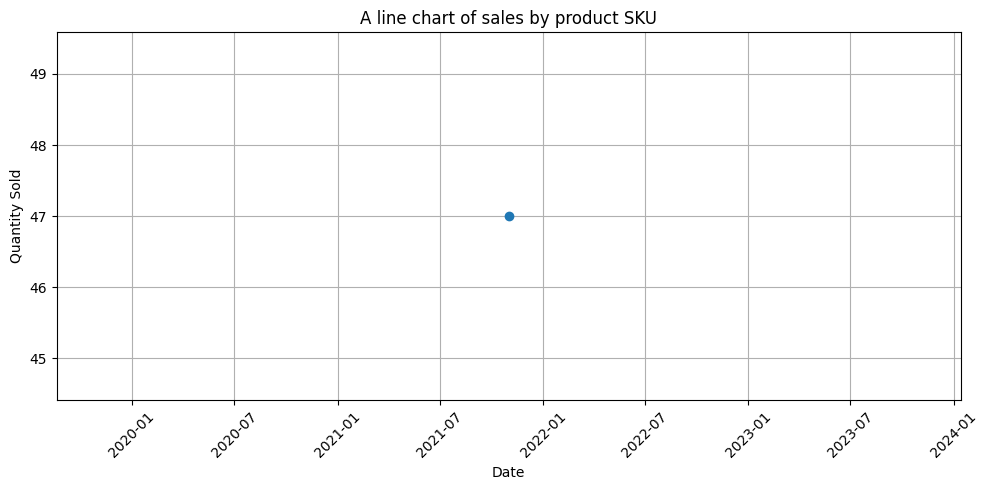

In [25]:
exec(code)

## Defining the Router

Now that all of the tools are defined, you can create the router. The router will take the original user input, and is responsible for calling any tools. After each tool call is completed, the agent will return to router to determine whether another tool should be called.

### Tool Schema

Let's define the tools in a way that can be understood by our OpenAI model. OpenAI understands a specific JSON format:

In [26]:
# Define tools/functions that can be called by the model
tools = [
    {
        "type": "function",
        "function": {
            "name": "lookup_sales_data",
            "description": "Look up data from Store Sales Price Elasticity Promotions dataset",
            "parameters": {
                "type": "object",
                "properties": {
                    "prompt": {"type": "string", "description": "The unchanged prompt that the user provided."}
                },
                "required": ["prompt"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "analyze_sales_data", 
            "description": "Analyze sales data to extract insights",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {"type": "string", "description": "The lookup_sales_data tool's output."},
                    "prompt": {"type": "string", "description": "The unchanged prompt that the user provided."}
                },
                "required": ["data", "prompt"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "generate_visualization",
            "description": "Generate Python code to create data visualizations",
            "parameters": {
                "type": "object", 
                "properties": {
                    "data": {"type": "string", "description": "The lookup_sales_data tool's output."},
                    "visualization_goal": {"type": "string", "description": "The goal of the visualization."}
                },
                "required": ["data", "visualization_goal"]
            }
        }
    }
]

# Dictionary mapping function names to their implementations
tool_implementations = {
    "lookup_sales_data": lookup_sales_data,
    "analyze_sales_data": analyze_sales_data, 
    "generate_visualization": generate_visualization
}

### Router Logic

The router is composed of a main loop method, and a method to handle the tool calls that you get back from the model.

<img src="images/router.png" width="800"/>

The following two cells define the function `handle_tool_calls` and the variable `SYSTEM_PROMPT`, which will be used by the function `run_agent` defining the router logic.

In [27]:
# code for executing the tools returned in the model's response
@tracer.chain()
def handle_tool_calls(tool_calls, messages):
    
    for tool_call in tool_calls:   
        function = tool_implementations[tool_call.function.name]
        function_args = json.loads(tool_call.function.arguments)
        result = function(**function_args)
        messages.append({"role": "tool", "content": result, "tool_call_id": tool_call.id})
        
    return messages

In [28]:
SYSTEM_PROMPT = """
You are a helpful assistant that can answer questions about the Store Sales Price Elasticity Promotions dataset.
"""

In [29]:
def run_agent(messages):
    print("Running agent with messages:", messages)
    if isinstance(messages, str):
        messages = [{"role": "user", "content": messages}]
    if not any(
            isinstance(message, dict) and message.get("role") == "system" for message in messages
        ):
            system_prompt = {"role": "system", "content": SYSTEM_PROMPT}
            messages.append(system_prompt)

    while True:
        # Router Span
        print("Starting router call span")
        with tracer.start_as_current_span(
            "router_call", openinference_span_kind="chain",
        ) as span:
            span.set_input(value=messages)
            
            response = client.chat.completions.create(
                model=MODEL,
                messages=messages,
                tools=tools,
            )
            messages.append(response.choices[0].message.model_dump())
            tool_calls = response.choices[0].message.tool_calls
            print("Received response with tool calls:", bool(tool_calls))
            span.set_status(StatusCode.OK)
    
            if tool_calls:
                print("Starting tool calls span")
                messages = handle_tool_calls(tool_calls, messages)
                span.set_output(value=tool_calls)
            else:
                print("No tool calls, returning final response")
                span.set_output(value=response.choices[0].message.content)
                return response.choices[0].message.content

In [30]:
def start_main_span(messages):
    print("Starting main span with messages:", messages)
    
    with tracer.start_as_current_span(
        "AgentRun", openinference_span_kind="agent"
    ) as span:
        span.set_input(value=messages)
        ret = run_agent(messages)
        print("Main span completed with return value:", ret)
        span.set_output(value=ret)
        span.set_status(StatusCode.OK)
        return ret

In [31]:
result = start_main_span([{"role": "user", 
                           "content": "Which stores did the best in 2021?"}])

Starting main span with messages: [{'role': 'user', 'content': 'Which stores did the best in 2021?'}]
Running agent with messages: [{'role': 'user', 'content': 'Which stores did the best in 2021?'}]
Starting router call span
Received response with tool calls: True
Starting tool calls span
Starting router call span
Received response with tool calls: True
Starting tool calls span
Starting router call span
Received response with tool calls: False
No tool calls, returning final response
Main span completed with return value: The best-performing stores in 2021, based on total sale value and quantity sold, are:

1. **Store 0 (2970)**:  
   - Total Sale Value: $84,454.33  
   - Total Quantity Sold: 5,867  

2. **Store 1 (3300)**:  
   - Total Sale Value: $63,205.33  
   - Total Quantity Sold: 5,124  

3. **Store 2 (1650)**:  
   - Total Sale Value: $62,152.43  
   - Total Quantity Sold: 4,673  

Store 0 stands out as the top performer in both metrics, indicating strong overall financial perfo

In [32]:
print(result)
# you can also print a formatted version of the result
# Markdown(result)

The best-performing stores in 2021, based on total sale value and quantity sold, are:

1. **Store 0 (2970)**:  
   - Total Sale Value: $84,454.33  
   - Total Quantity Sold: 5,867  

2. **Store 1 (3300)**:  
   - Total Sale Value: $63,205.33  
   - Total Quantity Sold: 5,124  

3. **Store 2 (1650)**:  
   - Total Sale Value: $62,152.43  
   - Total Quantity Sold: 4,673  

Store 0 stands out as the top performer in both metrics, indicating strong overall financial performance and customer demand.
